# INSY 669: Text Analytics Final Project
## Resume to Job Matcher

##### Alfonso Cabello
##### Sophie Courtemanche-Martel
##### Jake Hogan
##### Duncan Wang

**Objective**: 

Nowadays, landing your dream job can be more difficult than ever. Companies are increasingly relying on automated technologies to process prospective applicants, and with the rise of Applicant Tracking Systems (ATS) which filter and rank applicants by their fit to a job posting, it is estimated that 75% of resumes never even reach the hands of a recruiter. The objective of this project is to simplify the application process for job seekers, help them identify which jobs to target, and to increase their chances of bypassing ATS systems and landing their ideal role. 

To do so, our project will allow a job seeker to input their resume and a target industry or role, and perform the following:
1. Match users to postings they are most qualified for based on the similarity scoring between their resume and a job description
2. Use topic modeling (LDA) to identify key "themes", representing requirements or ideal traits an industry or role is looking for, and use similarity scoring to assess a user's fit to top requirements in that industry or role. 
3. Use Inverse-Document Frequency to cluster jobs together to present a condensed view of what an industry looks like, and present what the top requirements of each cluster of companies is. 

**Contents**: <br>
**1. Preprocessing - grab job descriptions**<br>
**2. Preprocessing - grab resumes**<br>
**3. Preprocessing - cleaning, tokenization, lemmatization, etc.**<br>
**4. Task 1. Top jobs for user: Similarity scoring**<br>
**5. Task 2: User fit-to industry or job: Topic modeling using LDA**<br>
**6. Demo**<br>
**7. Clustering**

---

## Import Required Packages and Set Directory

In [1]:
import pandas as pd
import numpy as np
from serpapi import GoogleSearch
import string
import nltk
#nltk.download('wordnet') -- if package is not up to date
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.tokenize import PunktSentenceTokenizer,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import gensim
from gensim.test.utils import datapath
import math

#for LDA 
import lda
import PyPDF2
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle 
import pyLDAvis


pd.options.mode.chained_assignment = None  # default='warn'

import os
import platform as pf
path = os.getcwd()
os_type = pf.system()

---

## Preprocessing Step 1. Grab job descriptions

Function to get scrape job descriptions from Google Jobs. User inputs their query as a string and the number of results they would like to receive, and the function returns a DataFrame with the results. `n_results` will round up to the nearest value of 10. <br>
The function will then drop duplicate results, so it is worth noting that **for this reason, the number of results may be slightly less than the specified number**. The function will improve results by eliminating duplicate postings.

In [2]:
def job_query(query, n_results = 10):
    n_results = int(math.ceil(n_results / 10.0))
    params = {
        "engine": "google_jobs",
        "q": query,
        "google_domain": "google.com",
        "api_key": 'b72a6c4ee9df45e8c49c6113ee62215c32e387f335ab4f0b4d7496745e0dfd2b'
    }

    client = GoogleSearch(params)
    data = client.get_dict()

    results = pd.DataFrame(data['jobs_results'])
    
    for i in range(1, n_results):
        params = {
            "engine": "google_jobs",
            "q": "data science jobs usa",
            "google_domain": "google.com",
            "start": 10*i,
            "api_key": 'b72a6c4ee9df45e8c49c6113ee62215c32e387f335ab4f0b4d7496745e0dfd2b'
        }

        client = GoogleSearch(params)
        data_append = client.get_dict()
        df_append = pd.DataFrame(data_append['jobs_results'])
        results = results.append(df_append, ignore_index = True)
        
    results = results.drop_duplicates(subset = 'description')
    results = results.reset_index()
    results = results.drop('index', axis = 'columns')
    
    return(results)

In [3]:
#specify industry and number of job postings wanted
results = job_query('data science jobs usa', 100)
results.to_csv('descriptions_unclean.csv', index = False)

In [4]:
#open as csv file
if os_type == 'Windows':
    df = pd.read_csv(path + r'\descriptions_unclean.csv')
else: 
    df = pd.read_csv(path + '/descriptions_unclean.csv')

In [5]:
df_unclean = df.copy()
df_unclean.head(4)

,title,company_name,location,via,description,extensions,job_id
0,Data Scientist,Apple,"Cupertino, CA",via Jobs At Apple,"Summary\nPosted: Oct 9, 2020\nWeekly Hours: 40...","['Over 1 month ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...
1,"Data Scientist, Engineering",Google,"Mountain View, CA",via Google Careers,"As a Data Scientist, you will evaluate and imp...","['Over 1 month ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCwgRW5naW...
2,Data Scientist,Central Intelligence Agency,"Washington, DC",via USAJOBS - Job Announcement,"As a Data Scientist for the CIA, you will orga...","['Over 1 month ago', '63,503 a year', 'Full-ti...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...
3,Product Data Scientist - Ads Data Science,Twitter,"San Francisco, CA",via SmartRecruiters Jobs,Job Description\n\nWho We Are:\n\nThe team is ...,"['2 days ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJQcm9kdWN0IERhdGEgU2NpZW50aX...


---

## Preprocessing Step 2. Grab resumes

Ideally, resumes will be read as pdf directly from online storage (i.e. Github), saved onto a local folder, and PDF miner would be used to extract the text from the PDF files. There were some issues with system compatability depending on who was running the code, so we have completed the pre-processing of the resume PDFs and stored the output as a CSV on Github. For the purposes of the project, the cleaned CSV output of the below process will be read directly from Github.

In [6]:
'''
import pdfminer
from pdfminer.high_level import extract_text, extract_text_to_fp
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

import sys
print(pdfminer.__version__) 

if sys.version_info > (3, 0):
    from io import StringIO
else:
    from io import BytesIO as StringIO
    

import os
import platform as pf
path = os.getcwd()
os_type = pf.system()

#get path to resumes and write the names of all the resumes to a list
if os_type == 'Windows':
    resume_list = os.listdir(path+ r'\Resumes')
    resume_list.remove('.ipynb_checkpoints')
    print(resume_list)

    #create a dataframe to store resumes
    resume_content_list = []

    #read the content in the resume as one block and write to a list 
    for i in resume_list: 
        output_string = StringIO()
        with open(path+'\Resumes\''+i, 'rb') as resume:
            extract_text_to_fp(resume, output_string)
            resume_content_list.append(output_string.getvalue().strip())

    #create a new df to store the resumes
    resume_df = pd.DataFrame(resume_content_list, columns = ['resume'])
    resume_df

else: 
    resume_list = os.listdir(path+'/Resumes')
    resume_list.remove('.ipynb_checkpoints')
    print(resume_list)

    #create a dataframe to store resumes
    resume_content_list = []

    #read the content in the resume as one block and write to a list 
    for i in resume_list: 
        output_string = StringIO()
        with open(path+'/Resumes/'+i, 'rb') as resume:
            extract_text_to_fp(resume, output_string)
            resume_content_list.append(output_string.getvalue().strip())

    #create a new df to store the resumes
    resume_df = pd.DataFrame(resume_content_list, columns = ['description'])
resume_df
'''

<>:63: DeprecationWarning: invalid escape sequence \R
<>:63: DeprecationWarning: invalid escape sequence \R
<>:63: DeprecationWarning: invalid escape sequence \R
<ipython-input-6-4a5f0d21fe13>:63: DeprecationWarning: invalid escape sequence \R
  '''


"\nimport pdfminer\nfrom pdfminer.high_level import extract_text, extract_text_to_fp\nfrom pdfminer.converter import TextConverter\nfrom pdfminer.layout import LAParams\nfrom pdfminer.pdfdocument import PDFDocument\nfrom pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter\nfrom pdfminer.pdfpage import PDFPage\nfrom pdfminer.pdfparser import PDFParser\n\nimport sys\nprint(pdfminer.__version__) \n\nif sys.version_info > (3, 0):\n    from io import StringIO\nelse:\n    from io import BytesIO as StringIO\n    \n\nimport os\nimport platform as pf\npath = os.getcwd()\nos_type = pf.system()\n\n#get path to resumes and write the names of all the resumes to a list\nif os_type == 'Windows':\n    resume_list = os.listdir(path+ r'\\Resumes')\n    resume_list.remove('.ipynb_checkpoints')\n    print(resume_list)\n\n    #create a dataframe to store resumes\n    resume_content_list = []\n\n    #read the content in the resume as one block and write to a list \n    for i in resume_list: \n 

In [7]:
import pandas as pd
url = 'https://raw.githubusercontent.com/duncan-wang/resume-job-matcher/main/Resumes/resumes.csv'
resume_df = pd.read_csv(url, error_bad_lines=False)
resume_df

,description
0,Sophie Courtemanche-Martel (514) 663-5613 • ...
1,James Hogan (978) 972 0082 • james.hogan2@ma...
2,Alfonso Cabello alfonso.cabello@mail.mcgill...
3,Duncan Wang (438) 888-1998 • duncan.wang@mail...


---

## Preprocessing Step 3: Clean Resumes & Jobs

Now that we have the jobs and CSVs, we will clean them in preparation for analysis. This includes replacement of a few key phrases, removing punctuation, whitespace, stopwords, replacing numbers with words, tokenization, and lemmentization. 

#### Cleaning

In [8]:
#for example purposes, we are focusing on data science jobs only. Here, we replace a few key terms.

def keyword_replace(text):
    text = text.replace("machine learning", "ml")
    text = text.replace("data scientist", "datascientist")
    text = text.replace("data science", "datascience")
    text = text.replace("artificial intelligence", "ai")
    text = text.replace("neural network", "neuralnetwork")
    text = text.replace("business intelligence", "businessintelligence")
    text = text.replace("data analysis", "dataanalysis")
    text = text.replace("data analytics", "dataanalysis")
    text = text.replace("data engineering", "dataengineering")
    return(text)

In [9]:
def clean_df(df_col):
    temp = df_col.reset_index()
    if type(temp['description'][0]) != str:
        return(df_col)
    df_col = df_col.astype('str')
    #replacing some key phrases (machine learning -> ml, data scientist -> datascientist, data science -> datascience)
    df_col = np.array([keyword_replace(x) for x in list(df_col)])
    #remove punctuation
    df_col = np.array(list(x.translate(str.maketrans("","", (string.punctuation+'•`’'))) for x in list(df_col)))
    #lowercase
    df_col = np.array([x.lower() for x in list(df_col)])
    #remove whitespace
    df_col = np.array([x.strip() for x in list(df_col)])
    #tokenization
    df_col = np.array([word_tokenize(x) for x in list(df_col)])
    #remove stopwords
    sw = set(stopwords.words('english'))
    df_col = np.array([[i for i in x if i not in sw] for x in list(df_col)])
    #replacing numbers with words
    array = np.array([['0', 'zero'], ['1', 'one'], ['2', 'two'], ['3', 'three'], ['4', 'four'], ['5', 'five'], ['6', 'six'], ['7', 'seven'], ['8', 'eight'], ['9', 'nine'], ['10', 'ten'], ['12', 'twelve'], ['20', 'twenty']])
    nums = pd.DataFrame(array, columns = ['Number', 'Word'])
    for x in list(df_col):
        for idx, number in enumerate(x):
            if number in list(nums['Number']):
                x[idx] = nums[nums['Number'] == number]['Word'].to_list()[0]
    #removing numbers
    for toke in list(df_col):
        for idx, i in enumerate(toke):
            toke[idx] = re.sub(r'\d+', '', i)
    toke = list(filter(lambda y: y != '', toke))
    
    for x in df_col:
        while '' in x:
            x.remove('')
    return(df_col)

In [10]:
#takes as input a single string and cleans 
def clean_str(test):
    if type(test) != str:
        return(test)
    #replacing some key phrases (machine learning -> ml, data scientist -> datascientist, data science -> datascience)
    test = keyword_replace(test)
    #lowercase
    test = test.lower()
    #remove punctuation
    test = test.translate(str.maketrans("","", (string.punctuation+'•`’')))
    #remove whitespace
    test = test.strip()
    #tokenization
    toke = word_tokenize(test)
    #remove stopwords
    sw = set(stopwords.words('english'))
    toke = [i for i in toke if i not in sw]
    #replacing numbers
    array = np.array([['0', 'zero'], ['1', 'one'], ['2', 'two'], ['3', 'three'], ['4', 'four'], ['5', 'five'], ['6', 'six'], ['7', 'seven'], ['8', 'eight'], ['9', 'nine'], ['10', 'ten'], ['12', 'twelve'], ['20', 'twenty']])
    nums = pd.DataFrame(array, columns = ['Number', 'Word'])
    for idx, number in enumerate(toke):
        if number in list(nums['Number']):
            toke[idx] = nums[nums['Number'] == number]['Word'].to_list()[0]
    #removing numbers
    for idx, i in enumerate(toke):
        toke[idx] = re.sub(r'\d+', '', i)
    toke = list(filter(lambda x: x != '', toke))
    
    return(toke)

#### Lementization

In [11]:
def lemmatize_descriptions(df_descriptions):
    df_descriptions['description'] = clean_df(df_descriptions['description'])
    copy = df_descriptions.copy()
    desc_idx = 0
    for i in range(len(copy.columns)):
        if list(copy.columns)[i] == 'description':
            desc_idx = i #getting the index of the description column to put the lemmatized version next to it
    lemmatizer = WordNetLemmatizer()
    lemmatized = np.array([[lemmatizer.lemmatize(word) for word in x] for x in list(copy['description'])])
    if 'description_lemmatized' not in list(copy.columns):
        copy.insert(desc_idx+1, 'description_lemmatized', lemmatized)
    return(copy)

#### Clean Descriptions

Apply above functions to descriptions:

In [12]:
df['description'] = clean_df(df['description'])
df['description'] = clean_str(df['description'])
df = lemmatize_descriptions(df)
df.head(4)

,title,company_name,location,via,description,description_lemmatized,extensions,job_id
0,Data Scientist,Apple,"Cupertino, CA",via Jobs At Apple,"[summary, posted, oct, nine, weekly, hours, ro...","[summary, posted, oct, nine, weekly, hour, rol...","['Over 1 month ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...
1,"Data Scientist, Engineering",Google,"Mountain View, CA",via Google Careers,"[data, scientist, evaluate, improve, googles, ...","[data, scientist, evaluate, improve, google, p...","['Over 1 month ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCwgRW5naW...
2,Data Scientist,Central Intelligence Agency,"Washington, DC",via USAJOBS - Job Announcement,"[data, scientist, cia, organize, interpret, da...","[data, scientist, cia, organize, interpret, da...","['Over 1 month ago', '63,503 a year', 'Full-ti...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...
3,Product Data Scientist - Ads Data Science,Twitter,"San Francisco, CA",via SmartRecruiters Jobs,"[job, description, team, responsible, placing,...","[job, description, team, responsible, placing,...","['2 days ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJQcm9kdWN0IERhdGEgU2NpZW50aX...


#### Clean Resumes

Apply above functions to resumes

In [13]:
#add name column 
def listToString(s):  
    str1 = " "  
    return (str1.join(s)) 

resume_df['name'] = 0
for i in range(len(resume_df)):
    resume_df['name'][i] = listToString(resume_df['description'][i].split()[:2])

    
#clean resume descriptions using function
resume_df['description'] = clean_df(resume_df['description'])
resume_df['description'] = clean_str(resume_df['description'])
resume_df = lemmatize_descriptions(resume_df)
resume_df.head(4)

,description,description_lemmatized,name
0,"[sophie, courtemanchemartel, sophiecourtemanch...","[sophie, courtemanchemartel, sophiecourtemanch...",Sophie Courtemanche-Martel
1,"[james, hogan, jameshoganmailmcgillca, wwwlink...","[james, hogan, jameshoganmailmcgillca, wwwlink...",James Hogan
2,"[alfonso, cabello, alfonsocabellomailmcgillca,...","[alfonso, cabello, alfonsocabellomailmcgillca,...",Alfonso Cabello
3,"[duncan, wang, duncanwangmailmcgillca, linkedi...","[duncan, wang, duncanwangmailmcgillca, linkedi...",Duncan Wang


---

## Task 1. Top jobs for user: Similarity scoring 

**What jobs are you most fit for?**

Now, we want to compute the similiarity score between user and an industry of choice. Here we take our data science jobs and a user resume and show the user the top jobs they match to -- i.e. the jobs which have the highest similarity scores between their descriptions and the user resume.

The below function takes in as input a user resume and returns a DataFrame containing all job descriptions we have with similarity score. 


The user can choose the number of jobs to consider in similiarity scoring -- i.e. the top $n$ most similar jobs to the description (resume) input. The user can also specify `n_jobs` to return however many jobs they desire.

Note that lemmatization will only be applied to the descriptions and resumes in Task 2: topic modeling. We choose this because we assume that an ATS system will not look for lemmatized words, thus we want to look for an exact match for topic modelling.

In [14]:
#allow user to enter name directly
def name(name):
    name = resume_df['description'][resume_df[resume_df['name'] == name].index[0]]
    return name

#inputs = resume, jobs dataframe, number of jobs to consider in similarity scoring, and number of jobs to output.
def top_matches(description, comparison_desc = df, common_count = 10, n_jobs = 3):
    if type(comparison_desc) != pd.DataFrame: #making function more robust to inputs
        comparison_desc = pd.DataFrame({'description': [comparison_desc]})
    
    df_func = comparison_desc.copy()
    df_func['description'] = clean_df(df_func['description'])
    df_func['description'] = np.array([" ".join(x) for x in df_func['description']]) #converting tokens to strings
    
    #allow user to query name directly 
    #taking the description string and cleaning/tokenizing
    description = clean_str(name(description))
    #Counting the 10 most frequently occuring words in the description to be compared
    from collections import Counter
    Counter = Counter(description)
    words_to_consider = min(common_count, len(description)) #if the number of words to consider was more than the words given, use all words given
    most = Counter.most_common(words_to_consider)
    attributes = [tup[0] for tup in most]
    attributes = " ".join(attributes)

    tempDataFrame = pd.DataFrame({'Job_Description':[attributes]})
    tempDataFrame = tempDataFrame.transpose()
    description_list1 = df_func['description']
    frames = [tempDataFrame, description_list1]
    result = pd.concat(frames)
    result.columns = ['description']
    result = result.reset_index()

    #building bag of words using frequency
    vec_words = CountVectorizer(decode_error='ignore')
    total_features_words = vec_words.fit_transform(result['description'])
    #print("The size of the vocabulary space:")
    #print(total_features_words.shape)

    #Calculating pairwise cosine similarity
    subset_sparse = sparse.csr_matrix(total_features_words)
    total_features_review = subset_sparse
    total_features_attr = subset_sparse[0,]
    similarity = 1 - pairwise_distances(total_features_attr,total_features_review, metric='cosine')

    #Assigning the similarity score to dataframe
    #similarity=np.array(similarities[0]).reshape(-1,).tolist()
    similarity = pd.DataFrame(similarity)
    similarity = similarity.transpose()
    similarity.columns = ['similarity']
    similarity = similarity.drop(similarity.index[[0]])
    scores_df = comparison_desc.assign(similarity=100*similarity.values)
    
    scores_df = lemmatize_descriptions(scores_df)
    
    return(scores_df.sort_values(by = 'similarity', ascending = False).head(n_jobs)[['title', 'company_name', 'location', 'description', 'description_lemmatized', 'job_id', 'similarity']])

In [15]:
def sim_description(description, comparison_desc = df, common_count = 10):
    if type(comparison_desc) != pd.DataFrame: #making function more robust to inputs
        comparison_desc = pd.DataFrame({'description': [comparison_desc]})
    
    df_func = comparison_desc.copy()
    df_func['description'] = clean_df(df_func['description'])
    df_func['description'] = np.array([" ".join(x) for x in df_func['description']]) #converting tokens to strings
    
    
    description = clean_str(description) #taking the description string and cleaning/tokenizing
    #Counting the 10 most frequently occuring words in the description to be compared
    from collections import Counter
    Counter = Counter(description)
    words_to_consider = min(common_count, len(description)) #if the number of words to consider was more than the words given, use all words given
    most = Counter.most_common(words_to_consider)
    attributes = [tup[0] for tup in most]
    attributes = " ".join(attributes)

    tempDataFrame = pd.DataFrame({'Job_Description':[attributes]})
    tempDataFrame = tempDataFrame.transpose()
    description_list1 = df_func['description']
    frames = [tempDataFrame, description_list1]
    result = pd.concat(frames)
    result.columns = ['description']
    result = result.reset_index()

    #building bag of words using frequency
    vec_words = CountVectorizer(decode_error='ignore')
    total_features_words = vec_words.fit_transform(result['description'])
    #print("The size of the vocabulary space:")
    #print(total_features_words.shape)

    #Calculating pairwise cosine similarity
    subset_sparse = sparse.csr_matrix(total_features_words)
    total_features_review = subset_sparse
    total_features_attr = subset_sparse[0,]
    similarity = 1 - pairwise_distances(total_features_attr,total_features_review, metric='cosine')

    #Assigning the similarity score to dataframe
    #similarity=np.array(similarities[0]).reshape(-1,).tolist()
    similarity = pd.DataFrame(similarity)
    similarity = similarity.transpose()
    similarity.columns = ['similarity']
    similarity = similarity.drop(similarity.index[[0]])
    scores_df = comparison_desc.assign(similarity=100*similarity.values)
    
    return(scores_df.sort_values(by = 'similarity', ascending = False))

**Example Outputs**

Here, we input various user resumes which gives us the top job matches.

In [16]:
sophie = top_matches('Sophie Courtemanche-Martel', n_jobs = 3)
sophie

,title,company_name,location,description,description_lemmatized,job_id,similarity
17,Senior Data Scientist,Handshake,"Denver, CO","[handshake, number, one, site, college, studen...","[handshake, number, one, site, college, studen...",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBTY2llbnRpc3...,11.501093
61,Data Scientist,Mojang,"Redmond, WA","[mojang, studios, minecraft, game, make, looki...","[mojang, studio, minecraft, game, make, lookin...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,7.416569
15,"Senior Data Scientist, Global Process Engineer...",DELL,Anywhere,"[senior, data, scientist, global, process, eng...","[senior, data, scientist, global, process, eng...",eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBTY2llbnRpc3...,6.271472


In [17]:
alfonso = top_matches('Alfonso Cabello', n_jobs = 4)
alfonso

,title,company_name,location,description,description_lemmatized,job_id,similarity
18,Lead Data Scientist,Abercrombie and Fitch Co.,"Columbus, OH","[company, description, company, abercrombie, f...","[company, description, company, abercrombie, f...",eyJqb2JfdGl0bGUiOiJMZWFkIERhdGEgU2NpZW50aXN0Ii...,26.954246
77,Data Scientist,Guardian Eagle,"Boca Raton, FL","[data, scientist, boca, raton, fl, fulltime, d...","[data, scientist, boca, raton, fl, fulltime, d...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,24.186308
62,Data Science Engineer,Stripe,"San Francisco, CA","[generate, insights, impact, data, stripe, bes...","[generate, insight, impact, data, stripe, best...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgRW5naW5lZX...,23.026947
48,Data Scientist in Minneapolis MN,General Mills,"Minneapolis, MN","[see, patterns, opportunities, others, dont, s...","[see, pattern, opportunity, others, dont, see,...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBpbiBNaW...,23.002185


In [18]:
jake = top_matches('James Hogan', common_count = 30, n_jobs = 3)
jake

,title,company_name,location,description,description_lemmatized,job_id,similarity
77,Data Scientist,Guardian Eagle,"Boca Raton, FL","[data, scientist, boca, raton, fl, fulltime, d...","[data, scientist, boca, raton, fl, fulltime, d...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,20.729006
80,Data Scientist,Gtrantham,"Lenexa, KS","[grantham, students, forefront, everything, pa...","[grantham, student, forefront, everything, pas...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,18.804924
50,Data Scientist,Randstad US,"Atlanta, GA","[data, scientist, employs, big, data, technolo...","[data, scientist, employ, big, data, technolog...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,15.364342


In [19]:
duncan = top_matches('Duncan Wang', common_count = 10, n_jobs = 3)
duncan

,title,company_name,location,description,description_lemmatized,job_id,similarity
52,Lead Data Scientist,Nielsen,"Chicago, IL","[lead, data, scientist, data, science, usa, ch...","[lead, data, scientist, data, science, usa, ch...",eyJqb2JfdGl0bGUiOiJMZWFkIERhdGEgU2NpZW50aXN0Ii...,20.365396
80,Data Scientist,Gtrantham,"Lenexa, KS","[grantham, students, forefront, everything, pa...","[grantham, student, forefront, everything, pas...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,17.270446
29,Data Scientist,University of Pennsylvania,"Philadelphia, PA (+1 other)","[job, location, med, sch, richards, building, ...","[job, location, med, sch, richards, building, ...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,14.845392


---

## Task 2: User fit-to industry or job: Topic modeling using LDA

**How do you stack up to industry/role requirements?**

Here, perform topic modeling using LDA to identify predominant topics within the industry or role that the user has selected. Note that our search term is **data science jobs usa**, thus topics will be generated from corpora resulting from search results of this query. 

Topics can be generated either at the industry/role level (all jobs), or a specific job that the user wants to consider (individual posting level). Then, we will generate the similarity score between a user's resume and each of these generated topics. We show the user the topics which they are most similar to, and those which they are least similar to to provide suggestions which they can tailor their resume to.

Unlike Task 1, here we use lemmatized job descriptions and resumes as we want to assess general fit for dominant topics within a job role/industry rather than an exact word-by-word match.

In [20]:
#Takes as input a user's resume, the description(s) that they want recommendations for
#and an optional parameter which allows the user to specify the number of topics which they want modeled for the description(s) entered.

def name2(name):
    name = resume_df['description_lemmatized'][resume_df[resume_df['name'] == name].index[0]]
    return name

def user_info(resume, descriptions, n_topics = 6):
    
    #first clean the resume
    #allow user to query name directly 
    resume = clean_str(name2(resume))
    # Create Dictionary
    if type(descriptions) != pd.Series:
        description = np.array([descriptions]) # description must be in array or Series format
    else:
        description = descriptions
    id2word = corpora.Dictionary(description)
    # Create Corpus
    texts = description
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    # Final optimized model

    k = n_topics
    alpha= .91
    beta = .91

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=k, 
                                               random_state=100,
                                               chunksize=100,
                                               passes=10,
                                               alpha=alpha,
                                               eta=beta)

    doc_lda = lda_model[corpus]

    # Dictionary with the keywords from each topic
    test_dict = dict()
    for i in range(k):
        str_out = lda_model.print_topics()[i][1] #get the formula containing the top keywords of this topic
        test_dict[i] = clean_str(str_out) #gets the top words from this topic

    sim_df = pd.DataFrame()
    for i in range(len(test_dict)):
        if 'data' in test_dict[i]:
            test_dict[i].remove('data') #noticed that data comes up often as a keyword
        sim_scores = sim_description(test_dict[i], comparison_desc = resume)
        sim_scores = sim_scores.rename(columns = {'similarity': 'Topic '+str(i)})
        sim_df = sim_df.append(other = sim_scores['Topic '+str(i)])
    sim_df = sim_df.rename(columns = {0: 'Input Similarity'})
    
    for word in range(3): #for each of the keywords in a topic
        sim_df['Topic Word ' + str(word+1)] = np.array([test_dict[topic][word] for topic in range(len(test_dict))]) #add the corresponding word to the dataframe
    
    
    highest_sim = sim_df.loc[sim_df['Input Similarity'].idxmax(), 'Input Similarity']
    lowest_sim = sim_df.loc[sim_df['Input Similarity'].idxmin(), 'Input Similarity']
    highest_sim_words = test_dict[int(sim_df['Input Similarity'].idxmax().split(' ')[1])]
    low_sim_words = test_dict[int(sim_df['Input Similarity'].idxmin().split(' ')[1])]
    high_sim_words = [word for word in highest_sim_words if word not in low_sim_words] #prioritize low similarity words for improvement, find words that aren't in low topics which appear in high sim topics
    if len(high_sim_words) < 3:
        high_sim_words = highest_sim_words
        
    print('Your highest similarity score was {} with corresponding topic words \'{}\', \'{}\', and \'{}\''.format(str(highest_sim), str(high_sim_words[0]), str(high_sim_words[1]), str(high_sim_words[2])))
    print('Your lowest similarity score was {} with corresponding topic words \'{}\', \'{}\', and \'{}\''.format(str(lowest_sim), str(low_sim_words[0]), str(low_sim_words[1]), str(low_sim_words[2])))
    
    return(sim_df)

**Example Output**

Here, we input the user's name and the jobs dataframe, and output a nummber of topics (default = 6) and the similarity score to each topic. We also get a user report for both the areas the user is performing best in, as well as the area the user is performing worst in -- via the topics that the user has the highest and lowest similarity score to.

In [21]:
jake_topics = user_info('James Hogan', df['description_lemmatized'])
jake_topics

Your highest similarity score was 15.135886972883327 with corresponding topic words 'experience', 'team', and 'business'
Your lowest similarity score was 0.0 with corresponding topic words 'treasury', 'roche', and 'patient'


,Input Similarity,Topic Word 1,Topic Word 2,Topic Word 3
Topic 0,15.135887,experience,team,business
Topic 1,0.000000,treasury,roche,patient
Topic 2,13.622298,experience,product,team
Topic 3,6.054355,experience,business,ca
Topic 4,10.595121,experience,ml,year
Topic 5,7.179582,school,penn,search


In [22]:
sophie_topics = user_info('Sophie Courtemanche-Martel', df['description_lemmatized'], n_topics = 4)
sophie_topics

Your highest similarity score was 16.14268624542523 with corresponding topic words 'experience', 'work', and 'team'
Your lowest similarity score was 0.0 with corresponding topic words 'pepsico', 'purpose', and 'eeo'


,Input Similarity,Topic Word 1,Topic Word 2,Topic Word 3
Topic 0,13.452239,experience,team,business
Topic 1,0.000000,pepsico,purpose,eeo
Topic 2,2.552383,sony,evonik,corporation
Topic 3,16.142686,experience,work,team


## Demo of Use Case

First a user inputs their resume.

In [23]:
jake = 'James Hogan'

Next, the user may be interested in finding the jobs which they are most similar to.

In [24]:
top_jobs = top_matches(jake, common_count = 25, n_jobs = 5)
top_jobs

,title,company_name,location,description,description_lemmatized,job_id,similarity
77,Data Scientist,Guardian Eagle,"Boca Raton, FL","[data, scientist, boca, raton, fl, fulltime, d...","[data, scientist, boca, raton, fl, fulltime, d...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,18.228958
80,Data Scientist,Gtrantham,"Lenexa, KS","[grantham, students, forefront, everything, pa...","[grantham, student, forefront, everything, pas...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,17.306092
50,Data Scientist,Randstad US,"Atlanta, GA","[data, scientist, employs, big, data, technolo...","[data, scientist, employ, big, data, technolog...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,15.353757
24,Data Scientist,University of Michigan,"Ann Arbor, MI (+1 other)","[apply, cover, letter, required, consideration...","[apply, cover, letter, required, consideration...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImNvbX...,14.978617
62,Data Science Engineer,Stripe,"San Francisco, CA","[generate, insights, impact, data, stripe, bes...","[generate, insight, impact, data, stripe, best...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgRW5naW5lZX...,14.688612


Finally, the user may be interested in how they can tailor their resume to these job listings above that were identified as a best fit.

In [25]:
user_info(jake, top_matches(jake, common_count = 25, n_jobs = 5)['description_lemmatized'], n_topics = 3)

Your highest similarity score was 22.70383045932499 with corresponding topic words 'senior', 'management', and 'knowledge'
Your lowest similarity score was 13.622298275595002 with corresponding topic words 'work', 'university', and 'team'


,Input Similarity,Topic Word 1,Topic Word 2,Topic Word 3
Topic 0,18.163064,team,knowledge,senior
Topic 1,13.622298,work,university,team
Topic 2,22.703830,senior,management,knowledge


**May need to change this since the description changed:**

Here, it looks like Jake intersects with the topic which contains words like 'team' and 'client' well (i.e. the soft skills). <br>
Conversely, the topic which contains words like 'data science' and 'machine learning' (i.e. the technical skills) overlap to a smaller degree. So, Jake may want to emphasize his technical skills on his resume a bit more in order ot intersect with these topics from his top job listings a bit more.

## Additional: Clustering companies by Term-Frequency/Inverse Document Frequency (TF-IDF) 

On top of an individualized report, we also want to show the user a bird's eye view of the industry, in case they just want to see the top requirements or "buzz words" that a group of companies can be characterized by. This provides two benefits: it allows the user to see which companies are similar or different to each other for comparison purposes, and allows them to identify which key terms may be prioritized by different groups of companies. 

To do so, we use Sklearn's Inverse-Document Frequency module to convert a collection of raw documents to a matrix of TF-IDF features. The output will generate a word cloud of the most important words to each group of job-postings (which increases with the number of times a word appears in a document, offset by the number of documents in a corpus contain that word), and also indicate which companies have been assigned to that cluster.

In [26]:
#prepare list of company names and their job descriptions -- here, the descriptions have already been cleaned and lemmatized. 
#Although the Sklearn package includes the cleaning process, we take the clean version just to be safe.
df['description_list'] = 0
for i in range(len(df)): 
    df['description_list'][i] = " ".join(df['description_lemmatized'][i])
    
company_list = []
job_list = []
for i in range(len(df)):
   job_list.append(df['description_list'][i])
   company_list.append(df['company_name'][i])

In [27]:
#use the TF-IDF vectorizer from sklearn to perform TF-IDF weighting and generate a vector 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(job_list)
X.shape

(81, 4349)

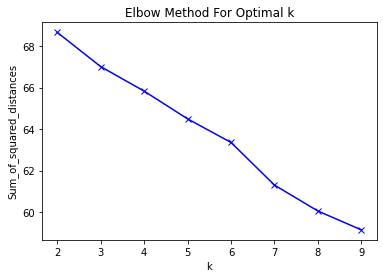

In [28]:
#use the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
#the sum of squared distances increases relatively linearly. For simplicity sake, we choose to plot 5 clusters.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=20, random_state = 100)
model.fit(X)
labels=model.labels_
cluster_assignments=pd.DataFrame(list(zip(company_list,labels)),columns=['title','cluster'])
print(cluster_assignments.sort_values(by=['cluster']))

                       title  cluster
23       Booz Allen Hamilton        0
78       Booz Allen Hamilton        0
46  Booz Allen Hamilton Inc.        0
73  Booz Allen Hamilton Inc.        0
10       Booz Allen Hamilton        0
..                       ...      ...
7                     Google        5
12                   Equifax        5
26                    Google        5
74                    Google        5
49                    Google        5

[81 rows x 2 columns]


Cluster: 0
Companies
      Booz Allen Hamilton
      Booz Allen Hamilton
 Booz Allen Hamilton Inc.
 Booz Allen Hamilton Inc.
      Booz Allen Hamilton


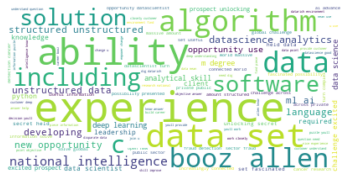

Cluster: 1
Companies
                   Twitter
                     Apple
               Capital One
        Lutron Electronics
                 Handshake
 Abercrombie and Fitch Co.
           Domino Data Lab
                   Walmart
               Capital One
            MessageControl
         USA TODAY NETWORK
      Evonik Industries AG
                 Microsoft
                     Apple
                  Wärtsilä
               Capital One
                 Recursion
                  Alphonso
                 Recursion
                     Intel
                       SAP
        Solar Lead Factory
               Capital One
                 proton.ai
            Bain & Company


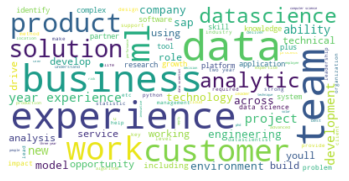

Cluster: 2
Companies
     University of Michigan
 University of Pennsylvania


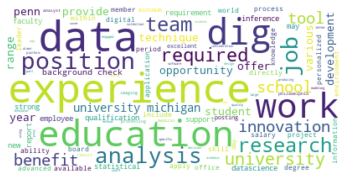

Cluster: 3
Companies
                         Apple
   Central Intelligence Agency
                     Microsoft
        McDonald's Corporation
                          eBay
                          DELL
             Dell Technologies
                      Bayer AG
                 Credit Suisse
                          True
         Eli Lilly and Company
            McKinsey & Company
                         Roche
                      LinkedIn
                          Sony
                       PepsiCo
                 General Mills
                   Randstad US
                    CitiusTech
                       Nielsen
                      Airtable
                    Riot Games
                       Carrier
                   Manceps Inc
                      Bayer AG
                        Mojang
                        Stripe
                     Honeywell
 US Department of the Treasury
                         Kelly
           Noblesoft Solutions
                  

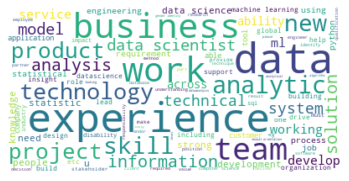

Cluster: 4
Companies
  Accenture
 Lucidworks
  Accenture
 Cerebri AI
   Vanguard
  Accenture
  Instacart
  Accenture


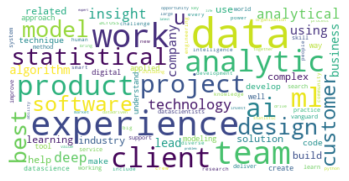

Cluster: 5
Companies
                   Google
                   Google
                  Equifax
                   Google
 Internal Revenue Service
                   Google
                   Google


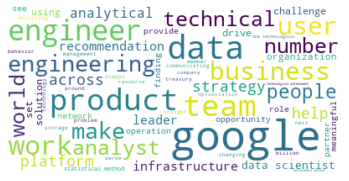

In [30]:
#Generate word cloud of clusters 
from wordcloud import WordCloud
result={'cluster':labels,'jobs':job_list}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['jobs'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Companies')
   titles=cluster_assignments[cluster_assignments.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

We can see several dominant clusters here. Cluster 1, which contains Google, Stripe, and Airtable, amongst others, seem to be very tech and product driven. Cluster 3, which is dominated by Booz Allen Hamilton and Accenture, have words such as "service" and "client", which makes sense since they are consulting firms who work with external clients. We can also see that cluster 5 is dominated by universities, and we can see terms such as "research" and "university" dominate. Overall, experience, and data seem to be one of the two most dominant words. This makes sense given the context of the job query.

## Additional insights: LDA topic visualization

In order to get further understanding of the topics on which there is more emphasis in the job descriptions. 

The package is designed to provide: 
1. Better understanding and interpreting of the individual topics
2. Better understanding of the relationship between the topics

In [38]:
#Select job descriptions and number of topics desired
descriptions = df['description_lemmatized']
n_topics = 10

#resume = clean_str(name2(resume))

# Create Dictionary
if type(descriptions) != pd.Series:
    description = np.array([descriptions]) # description must be in array or Series format
else:
    description = descriptions
id2word = corpora.Dictionary(description)
    
# Create Corpus
texts = description

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
# Final optimized model

k = n_topics
alpha= .91
beta = .91

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=k, 
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha,
                                            eta=beta)

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()

# Determine the number of topics that should be visualized 
num_topics = 15

## MAKE SURE THE FILE PATH IS CORRECT HERE 
LDAvis_data_filepath = os.path.join(r"C:\Users\Sophie\Downloads\ldavis_prepared_"+str(num_topics))


# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
    ## MAKE SURE TO USE THE SAME FILE PATH HERE AGAIN
pyLDAvis.save_html(LDAvis_prepared, r"C:\Users\Sophie\Downloads\ldavis_prepared_"+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.146012  0.005675       1        1  78.199546
6      0.017692  0.020381       2        1   7.272051
9      0.021452 -0.045653       3        1   6.709139
3     -0.011767  0.019020       4        1   4.622247
4     -0.020506  0.002774       5        1   0.927928
8     -0.026932  0.000223       6        1   0.911515
7     -0.029857 -0.000295       7        1   0.341101
1     -0.031904 -0.000655       8        1   0.338963
5     -0.032032 -0.000716       9        1   0.338818
2     -0.032157 -0.000752      10        1   0.338693, topic_info=            Term        Freq       Total Category  logprob  loglift
40          data  484.000000  484.000000  Default  30.0000  30.0000
318  datascience   93.000000   93.000000  Default  29.0000  29.0000
70    experience  329.000000  329.000000  Default  28.0000  28.0000
417        youll   47.000000   47.000000  Default  27.0000  27.0000
174        skill   86.000000   86.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
501     research    0.023281   53.521258  Topic10  -8.3123  -2.0523
471     learning    0.023206   82.505543  Topic10  -8.3155  -2.4884
38      customer    0.023178   96.941403  Topic10  -8.3167  -2.6508
426        build    0.023159   65.472851  Topic10  -8.3175  -2.2592
353  information    0.023155   56.041733  Topic10  -8.3177  -2.1038

[772 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
293       1  0.904623  ability
293       2  0.025482  ability
293       3  0.063706  ability
2490      1  0.526812   accept
267       1  0.644901   access
...     ...       ...      ...
1027      3  0.275699        —
794       1  0.780139        “
794       2  0.212765        “
795       1  0.711100        ”
795       2  0.213330        ”

[781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 10, 4, 5, 9, 8, 2, 6, 3])